# Importações


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import export_graphviz
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
!wget https://raw.githubusercontent.com/gabriel-bri/files/main/br_ibge_populacao_uf.csv
!wget https://github.com/gabriel-bri/files/raw/main/indicadoressegurancapublicauf.xlsx

--2024-09-21 21:25:59--  https://raw.githubusercontent.com/gabriel-bri/files/main/br_ibge_populacao_uf.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15440 (15K) [text/plain]
Saving to: ‘br_ibge_populacao_uf.csv’

br_ibge_populacao_u 100%[===================>]  15.08K  --.-KB/s    in 0s      

2024-09-21 21:25:59 (77.3 MB/s) - ‘br_ibge_populacao_uf.csv’ saved [15440/15440]

--2024-09-21 21:25:59--  https://github.com/gabriel-bri/files/raw/main/indicadoressegurancapublicauf.xlsx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabriel-bri/files/main/indicadoressegurancapublicauf.xlsx [followi

In [ ]:
dataSeg = pd.read_excel('/content/indicadoressegurancapublicauf.xlsx')
dataSeg = dataSeg.dropna()

In [ ]:
print(dataSeg.info())
print(dataSeg.head())
print(dataSeg.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23020 entries, 0 to 23019
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   UF           23020 non-null  object
 1   Tipo Crime   23020 non-null  object
 2   Ano          23020 non-null  int64 
 3   Mês          23020 non-null  object
 4   Ocorrências  23020 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 899.3+ KB
None
     UF                       Tipo Crime   Ano      Mês  Ocorrências
0  Acre                          Estupro  2022  janeiro           31
1  Acre                 Furto de veículo  2022  janeiro           50
2  Acre                 Homicídio doloso  2022  janeiro           10
3  Acre  Lesão corporal seguida de morte  2022  janeiro            1
4  Acre   Roubo a instituição financeira  2022  janeiro            0
                Ano   Ocorrências
count  23020.000000  23020.000000
mean    2018.485447    204.647828
std        2.282230    672.64994

# Lidando com o tamanho da populaçao

Como alguns Estados possuem uma população significativamente maior do que outros, é necessário tratar essa discrepância de forma adequada. Primeiramente, utilizaremos um outro dataset contendo os valores populacionais correspondentes. Em seguida, iremos filtrar os dados referentes aos anos de 2015 a 2021. Para o ano de 2022, repetiremos os valores de 2021, uma vez que os dados de 2022 não estarão disponíveis no dataset.



In [ ]:
populacao = pd.read_csv('/content/br_ibge_populacao_uf.csv')

populacao = populacao.drop(columns=['populacao_economicamente_ativa'])

# Filtrando os anos de 2015 até 2021
populacao_2015_2021 = populacao[(populacao['ano'] >= 2015) & (populacao['ano'] <= 2021)]

In [ ]:
estado_map = {
    'SP': 'São Paulo', 'RJ': 'Rio de Janeiro', 'MG': 'Minas Gerais', 'BA': 'Bahia',
    'RS': 'Rio Grande do Sul', 'PA': 'Pará', 'PR': 'Paraná','PB' : 'Paraíba', 'PE': 'Pernambuco', 'PI' : 'Piauí', 'CE': 'Ceará',
    'AC' : 'Acre', 'AL' : 'Alagoas', 'AP' : 'Amapá', 'AM' : 'Amazonas', 'DF' : 'Distrito Federal',
    'ES' : 'Espírito Santo', 'GO' : 'Goiás', 'MA' : 'Maranhão', 'MS' : 'Mato Grosso do Sul', 'MT' : 'Mato Grosso',
    'RN' : 'Rio Grande do Norte', 'RO' : 'Rondônia', 'RR' : 'Roraima', 'SC' : 'Santa Catarina', 'SE' : 'Sergipe',
    'TO' : 'Tocantins'
}

# Adicionando uma coluna com os nomes completos dos estados no dataset de população
populacao_2015_2021.loc[:, 'Estado'] = populacao_2015_2021['sigla_uf'].map(estado_map)



<ipython-input-6-e94a760c8f07>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  populacao_2015_2021.loc[:, 'Estado'] = populacao_2015_2021['sigla_uf'].map(estado_map)


In [ ]:
# Replicando os dados da populaçao de 2021 para 2022
populacao_2022 = populacao_2015_2021[populacao_2015_2021['ano'] == 2021].copy()
populacao_2022['ano'] = 2022

# Adicionando ao dataset de população
populacao = pd.concat([populacao_2015_2021, populacao_2022])
populacao = populacao[['Estado', 'ano', 'populacao']]


In [ ]:
dados_completos = pd.merge(dataSeg, populacao, how='left',
                           left_on=['UF', 'Ano'], right_on=['Estado', 'ano'])

print(dados_completos.head())

     UF                       Tipo Crime   Ano      Mês  Ocorrências Estado  \
0  Acre                          Estupro  2022  janeiro           31   Acre   
1  Acre                 Furto de veículo  2022  janeiro           50   Acre   
2  Acre                 Homicídio doloso  2022  janeiro           10   Acre   
3  Acre  Lesão corporal seguida de morte  2022  janeiro            1   Acre   
4  Acre   Roubo a instituição financeira  2022  janeiro            0   Acre   

    ano  populacao  
0  2022     906876  
1  2022     906876  
2  2022     906876  
3  2022     906876  
4  2022     906876  


In [ ]:
# Calculando crimes por 100 mil habitantes, para balancear a situaçao
dados_completos['Crimes por 100k habitantes']= (dados_completos['Ocorrências'] / dados_completos['populacao']) * 100000

#Criação dos Gráficos
Os gráficos serão utilizados para proporcionar uma melhor compreensão sobre a distribuição dos dados, o que influenciará a abordagem que será adotada com a rede.

In [ ]:
x = dados_completos[['UF', 'Tipo Crime', 'Ano', 'Mês']]
y = dados_completos['Ocorrências']

x = pd.get_dummies(x, drop_first=True)

In [ ]:
def plot_crimes_por_estado(dataSeg):
    crimes_por_estado = dataSeg.groupby('UF')['Ocorrências'].sum()

    plt.figure(figsize=(10,6))
    crimes_por_estado.plot(kind='bar', color='lightblue')
    plt.title('Total de Ocorrências de Crimes por Estado')
    plt.xlabel('Estado (UF)')
    plt.ylabel('Total de Ocorrências')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_tendencia_por_ano(dataSeg):
    crimes_por_ano = dataSeg.groupby('Ano')['Ocorrências'].sum()

    plt.figure(figsize=(10,6))
    crimes_por_ano.plot(marker='o', color='green')
    plt.title('Tendência de Crimes ao Longo dos Anos')
    plt.xlabel('Ano')
    plt.ylabel('Número de Ocorrências')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_crimes_por_tipo_e_mes(dataSeg):
    crimes_por_mes = dataSeg.groupby('Mês')['Ocorrências'].sum()
    crimes_por_tipo = dataSeg.groupby('Tipo Crime')['Ocorrências'].sum()

    # Gráfico por mês
    plt.figure(figsize=(10,6))
    crimes_por_mes.plot(kind='bar', color='lightcoral')
    plt.title('Total de Crimes por Mês')
    plt.xlabel('Mês')
    plt.ylabel('Número de Ocorrências')
    plt.xticks(rotation=45, ha='right')  # Ajusta a rotação para 45 graus e alinha à direita
    plt.tight_layout()
    plt.show()

    # Gráfico por tipo de crime
    plt.figure(figsize=(20,10))  # Aumenta o tamanho da figura para comportar mais texto
    crimes_por_tipo.plot(kind='bar', color='lightgreen')
    plt.title('Total de Crimes por Tipo de Crime')
    plt.xlabel('Tipo de Crime')
    plt.ylabel('Número de Ocorrências')
    plt.xticks(rotation=45, ha='right')  # Rotaciona 45 graus para melhorar a legibilidade
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_crimes_por_100k(dataSeg):
    crimes_por_100k = dataSeg.groupby('UF')['Crimes por 100k habitantes'].mean()

    plt.figure(figsize=(20,10))
    crimes_por_100k.plot(kind='bar', color='skyblue')
    plt.title('Crimes por 100 mil habitantes por Estado')
    plt.xlabel('Estado (UF)')
    plt.ylabel('Crimes por 100 mil habitantes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

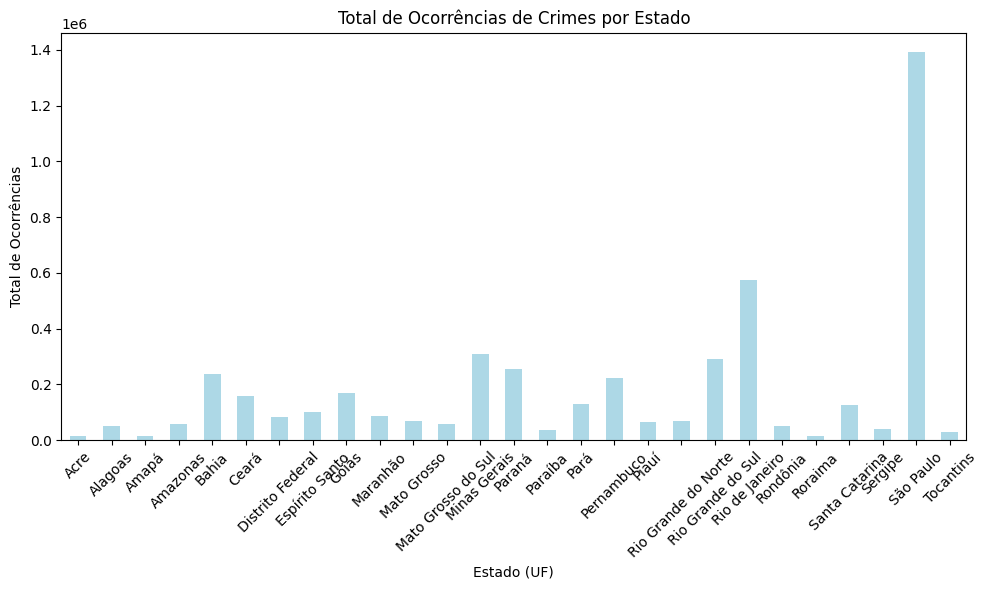

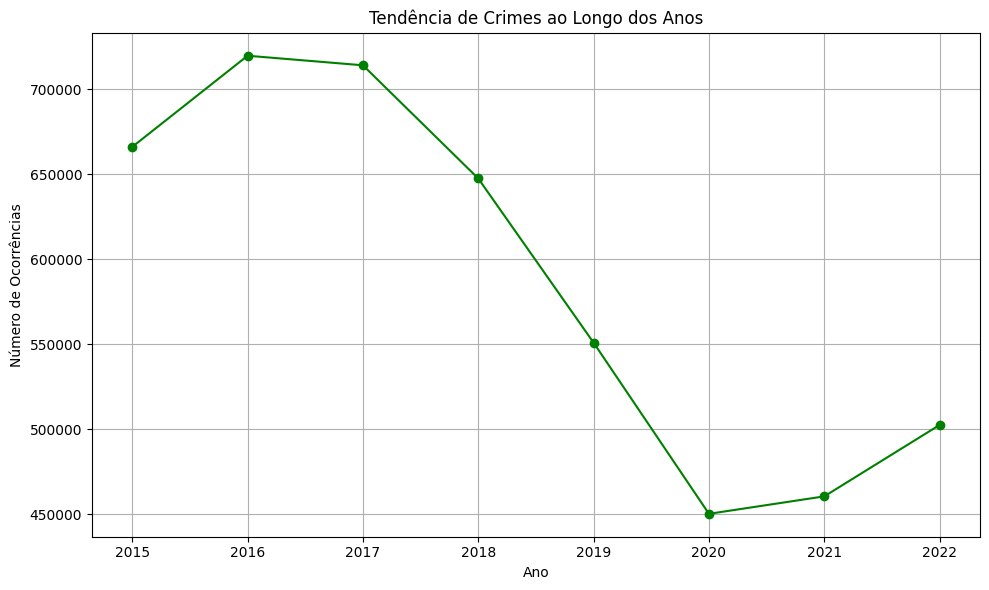

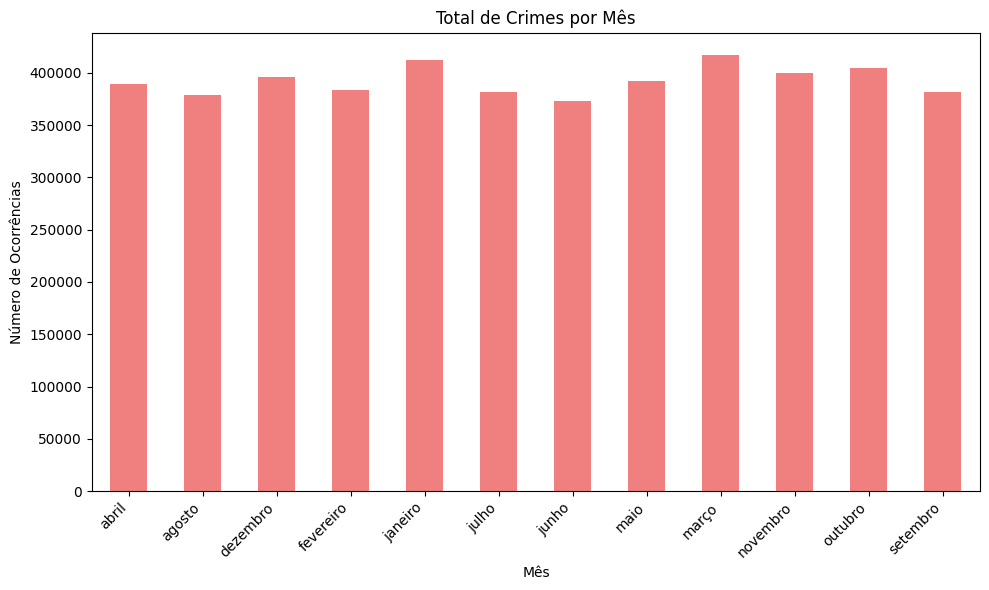

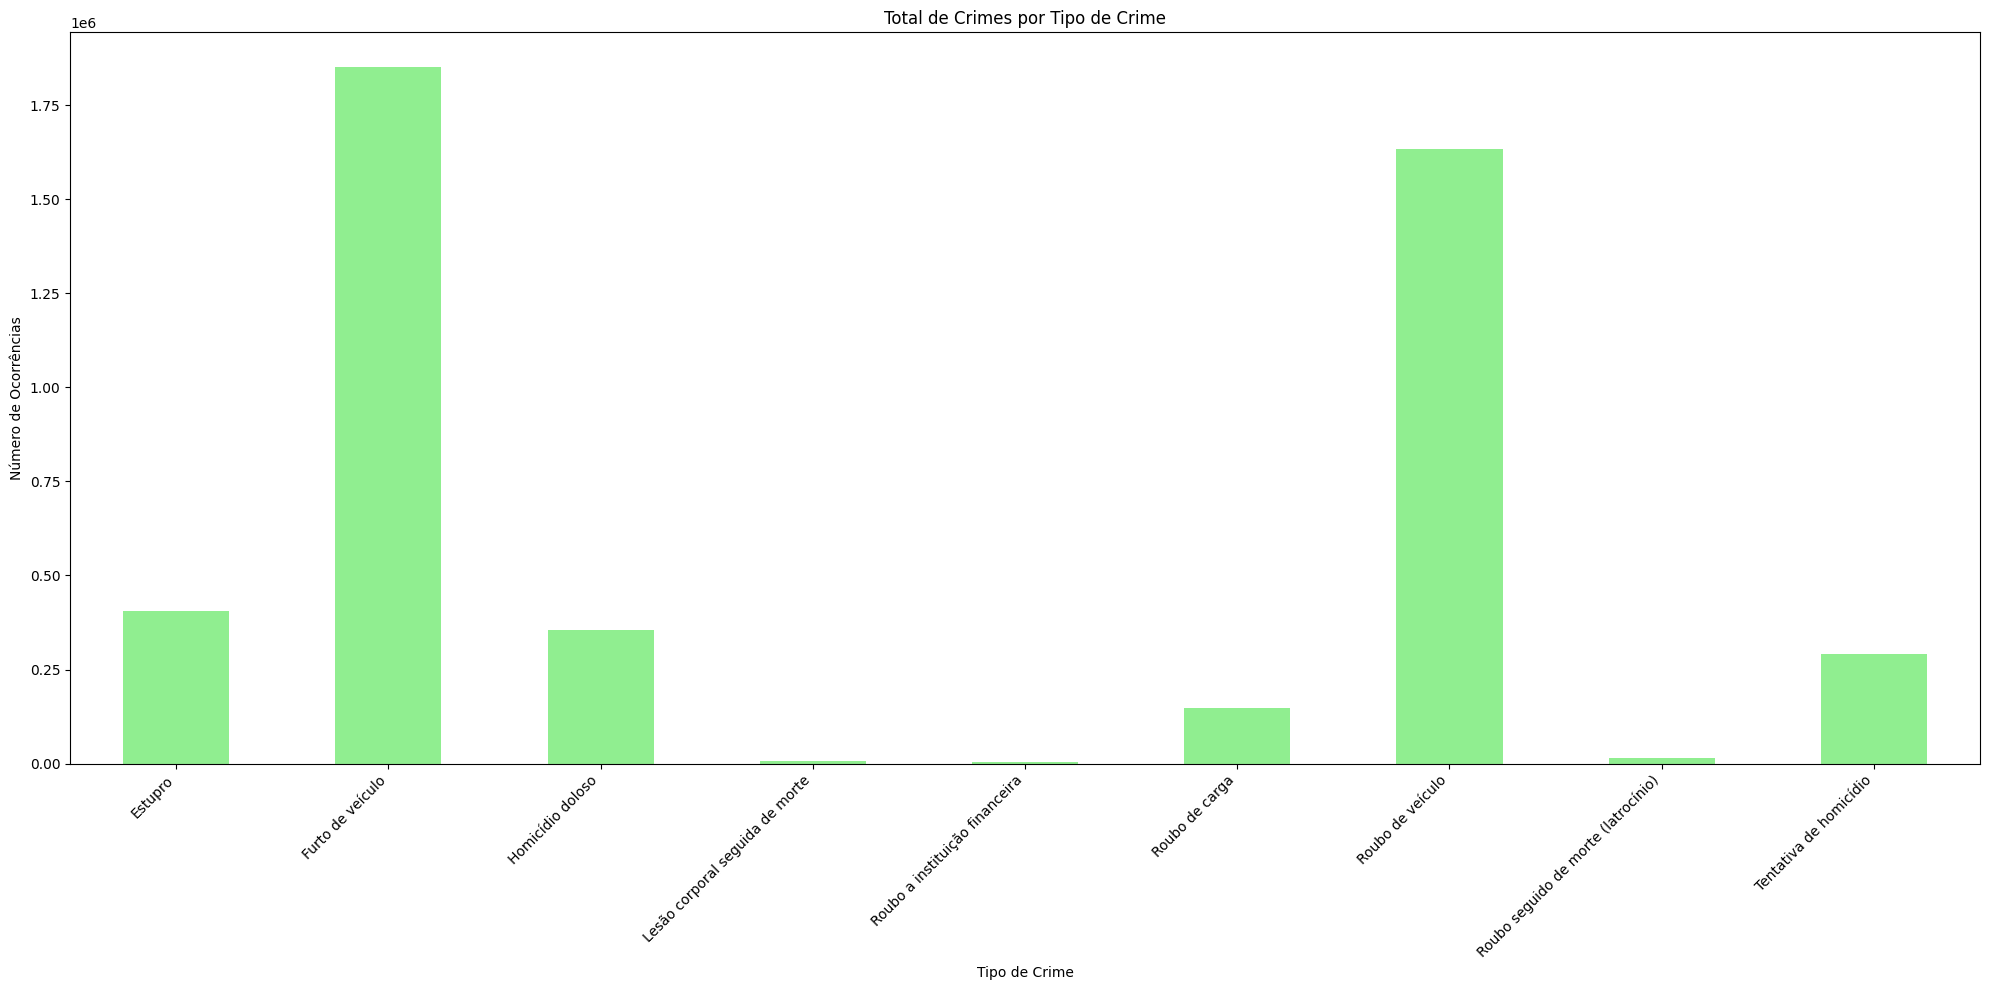

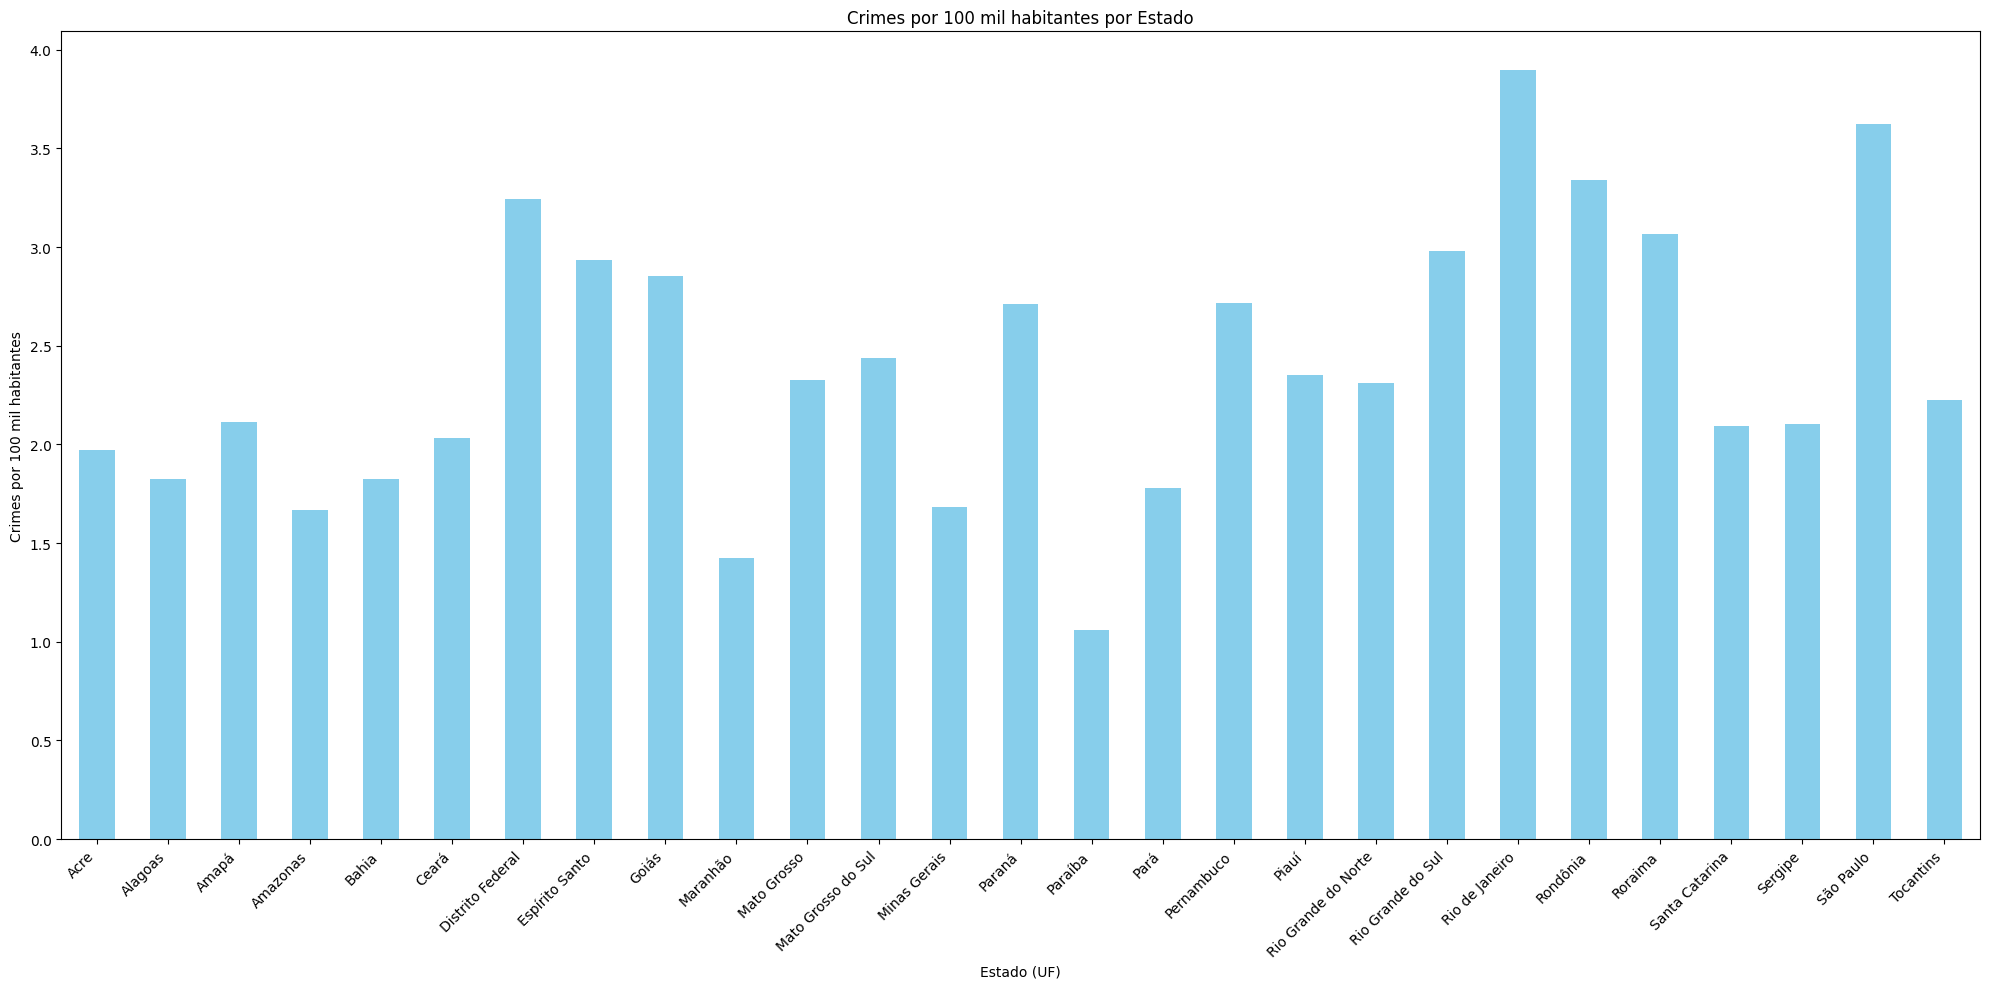

In [ ]:
def analise_exploratoria(dataSeg):
    plot_crimes_por_estado(dataSeg)
    plot_tendencia_por_ano(dataSeg)
    plot_crimes_por_tipo_e_mes(dataSeg)
    plot_crimes_por_100k(dataSeg)

analise_exploratoria(dados_completos)

# Rede Neural

In [ ]:
# Selecionando as features para o modelo, incluindo 'Crimes por 100k'
x = dados_completos[['UF', 'Tipo Crime', 'Ano', 'Mês', 'Crimes por 100k habitantes']]
x = pd.get_dummies(x, drop_first=True)  # Convertendo as variáveis categóricas

y = dados_completos['Ocorrências']

# Padronizando as features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Separando os dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)


In [ ]:
with open('x_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)
with open('x_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
rede_neural = MLPClassifier(max_iter = 1000, verbose=True)
rede_neural.fit(x_train, y_train)

#Será preciso decidir quantos neurônios de saída, ocultos, etc
# Testar e ver resultados usando quantidades diferentes de neurônios nas camadas ocultas hidden_layer_sizes = ()

Iteration 1, loss = 5.97658364
Iteration 2, loss = 4.67386814
Iteration 3, loss = 4.41512995
Iteration 4, loss = 4.24128335
Iteration 5, loss = 4.10869997
Iteration 6, loss = 3.99623733
Iteration 7, loss = 3.89193157
Iteration 8, loss = 3.79073711
Iteration 9, loss = 3.69333561
Iteration 10, loss = 3.59628766
Iteration 11, loss = 3.50034638
Iteration 12, loss = 3.40438613
Iteration 13, loss = 3.31363473
Iteration 14, loss = 3.22635170
Iteration 15, loss = 3.14327457
Iteration 16, loss = 3.06623843
Iteration 17, loss = 2.99673082
Iteration 18, loss = 2.93228835
Iteration 19, loss = 2.87318876
Iteration 20, loss = 2.82448758
Iteration 21, loss = 2.77491519
Iteration 22, loss = 2.73323160
Iteration 23, loss = 2.69329855
Iteration 24, loss = 2.65817034
Iteration 25, loss = 2.62450988
Iteration 26, loss = 2.59546658
Iteration 27, loss = 2.56248793
Iteration 28, loss = 2.53708915
Iteration 29, loss = 2.50798536
Iteration 30, loss = 2.48386896
Iteration 31, loss = 2.45902888
Iteration 32, los

MLPClassifier(max_iter=1000, verbose=True)

In [ ]:
previsao = rede_neural.predict(x_test)
accuracy_score(y_test, previsao)

print(classification_report(y_test, previsao))

              precision    recall  f1-score   support

           0       0.60      0.78      0.68       881
           1       0.31      0.16      0.21       504
           2       0.20      0.29      0.23       364
           3       0.13      0.11      0.12       203
           4       0.11      0.07      0.08       193
           5       0.07      0.04      0.05       140
           6       0.17      0.21      0.19       106
           7       0.10      0.08      0.09        96
           8       0.07      0.08      0.07        66
           9       0.15      0.08      0.11        75
          10       0.07      0.06      0.06        50
          11       0.07      0.04      0.05        47
          12       0.13      0.11      0.12        44
          13       0.10      0.09      0.10        45
          14       0.00      0.00      0.00        44
          15       0.02      0.03      0.02        33
          16       0.07      0.08      0.08        38
          17       0.03    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Primeira tentativa, usando tudo na forma mais padrão possível, conseguiu-se apenas resultados de 0.12483709817549957 ou 12%. Precisa-se haver um foco maior no que a rede irá fazer.

Na segunda tentativa, apos dar pesos com os 100k habitantes, conseguiu-se o resultado de 16%.

In [ ]:
#Salvando e carregando o modelo
with open('modelo_rede_neural.pkl', 'wb') as f:
    pickle.dump(rede_neural, f)

with open('modelo_rede_neural.pkl', 'rb') as f:
    rede_neural_carregada = pickle.load(f)